# Estimating and Error Components Model via GMM
### by [Jason DeBacker](https://jasondebacker.com), September 2025

This Jupyter Notebook illustrates how estimate the stationary error components model used in DeBacker, Heim, Panousi, Ramnath, and Vidangos (*Brookings Papers on Economic Activity*, Spring 2013) (hereafter, DHPRV).

## Moment conditions

The theoretical moment conditions are given by:

$$
g_{a,t,k}(\Theta_{0}) = E \left[cov(\xi^{i}_{a,t},\xi^{i}_{a+k,t+k})\right] -cov(a,t,k; \Theta_{0}) = 0
$$

Where $cov(a,t,k)$ are the theoretical covariances for individuals of age $a$, in year $t$, at lead $k$.  These are given as:

$$
\begin{split}
cov(a,t,k; \Theta)  = & \sigma^{2}_{\alpha} + \psi^{k}var(p^{i}_{a,t}) + \mathbf{1}[k=0](1+\mathbf{1}[a\geq2]\theta^{2}_{1}+\mathbf{1}[a\geq3]\theta^{2}_{2})\sigma^{2}_{\varepsilon} + \\
& \mathbf{1}[k=1](\theta_{1}+\mathbf{1}[a\geq2]\theta_{1}\theta_{2})\sigma^{2}_{\varepsilon} + \\
& \mathbf{1}[k=2]\theta_{2}\sigma^{2}_{\varepsilon}
\end{split}
$$

The sample analogue to these conditions are:

$$
\tilde{g}_{a,t,k}(\Theta_{0}) = \frac{\sum_{i=1}^{n}(\xi^{i}_{a,t}\xi^{i}_{a+k,t+k})}{n-1} -cov(a,t,k; \Theta_{0}) = 0
$$


Thus the first step in our method of moments estimator is to compute the covariances from the data.

## The data

We'll begin the exercise in this notebook by reading in a Stata data file that contains the computed sample covariances.  These were constructed from a panel of tax returns spanning the 1987 to 2009 period.  The unit of analysis are males, aged 25-60 with at least \$2,575 (in 2005\$) in labor income.  Labor income is defined as wages and salaries plus self-employment income.

The covariances are computed on the residuals from regressing the log of labor income on dummy variables for age, separately by year.

The covariances are then computed for all possible combinations of age, year, and lead.

Let's read in the data and look at it.

In [1]:
# import packages we'll use here
import pandas as pd
import numpy as np
import scipy.optimize as opt

In [10]:
# Read in the covariance data
covs_data = pd.read_stata('CovsData_labinc_CAL.dta')
covs_data.head(n=5)


,yrvar,hvar,jvar,hpjvar,covvar,wgtvar,covvarfd,wgtvarfd
0,1987,1,0,1,0.438955,329.0,NaN,NaN
1,1987,1,1,2,0.289566,306.0,NaN,NaN
2,1987,1,2,3,0.261525,302.0,NaN,NaN
3,1987,1,3,4,0.235245,290.0,NaN,NaN
4,1987,1,4,5,0.177744,283.0,NaN,NaN


In [11]:
covs_data.describe()

,yrvar,hvar,jvar,hpjvar,covvar,wgtvar,covvarfd,wgtvarfd
count,7912.000000,7912.000000,7912.000000,7912.000000,7912.000000,7912.000000,7084.000000,7084.000000
mean,1994.866279,15.366279,6.267442,21.633721,0.420291,232.583298,0.013806,213.861374
std,5.652031,9.071330,5.107145,9.071330,0.142618,51.062534,0.059922,45.461811
min,1987.000000,1.000000,0.000000,1.000000,0.089425,81.000000,-0.117507,76.000000
25%,1990.000000,8.000000,2.000000,15.000000,0.318830,201.000000,-0.011552,186.000000
50%,1994.000000,15.000000,5.000000,22.000000,0.403844,239.000000,-0.001709,218.000000
75%,1999.000000,22.000000,10.000000,29.000000,0.501245,268.000000,0.009143,245.000000
max,2009.000000,36.000000,22.000000,36.000000,1.031453,367.000000,0.377932,342.000000


We can see there are 7,912 different covariances measured from the data (we'll ignore the "fd", or first-differenced" covariances, and just estimate the model for the levels here).

The variables names are as follows:
* `yrvar` = year
* `hvar` = age
* `jvar` = lead
* `hpjvar` = age + lead
* `covvar` = covariance
* `wgtvar` = sample weights = number of observations used to compute the sample covariance.

# Clean the data

Now let's make a few adjustments to these data made in DHPRV.

In [12]:
# Clean the data
# drop if missing value for the covariance
covs_data = covs_data[covs_data.covvar.isnull() != True ]


# Define sample period, range of ages, etc.
year1 = 1987
year2 = 1988
yearT = 2009
minAge = 25
maxAge = 60
# Define cohorts - those who were 25 in 1952 were 60 in 1987
cohort1 = 1952  # first cohort
cohortT = 2009  # last cohort
# Put these parameters of the data in a tuple
sample_params = (year1, yearT, cohort1, cohortT, minAge, maxAge)

# * Create dummy variable Dj0, which equals 1 if jvar==0 and equals 0 otherwise
covs_data['Dj0'] = covs_data['jvar'] == 0

# ********************************************************************************
# * Pick observations used for estimation
# ********************************************************************************
covs_data['cohort'] = covs_data['yrvar'] - covs_data['hvar'] + 1
covs_data[(covs_data['cohort'] >= cohort1) & (covs_data['cohort'] <= cohortT)]
covs_data[(covs_data['yrvar'] >= year1) & (covs_data['yrvar'] <= yearT)]

# * Make sure that "future" years used to compute autocovariances do not fall
# * outside of [year1,yearT] range:
covs_data['yearpj'] = covs_data['cohort'] -1 + covs_data['hvar'] + covs_data['jvar']
covs_data[(covs_data['yearpj'] >= year1) & (covs_data['yearpj'] <= yearT)]
covs_data.describe()

,yrvar,hvar,jvar,hpjvar,covvar,wgtvar,covvarfd,wgtvarfd,cohort,yearpj
count,7912.000000,7912.000000,7912.000000,7912.000000,7912.000000,7912.000000,7084.000000,7084.000000,7912.000000,7912.000000
mean,1994.866279,15.366279,6.267442,21.633721,0.420291,232.583298,0.013806,213.861374,1980.500000,2001.133721
std,5.652031,9.071330,5.107145,9.071330,0.142618,51.062534,0.059922,45.461811,10.059474,5.652031
min,1987.000000,1.000000,0.000000,1.000000,0.089425,81.000000,-0.117507,76.000000,1952.000000,1987.000000
25%,1990.000000,8.000000,2.000000,15.000000,0.318830,201.000000,-0.011552,186.000000,1973.000000,1997.000000
50%,1994.000000,15.000000,5.000000,22.000000,0.403844,239.000000,-0.001709,218.000000,1980.500000,2002.000000
75%,1999.000000,22.000000,10.000000,29.000000,0.501245,268.000000,0.009143,245.000000,1988.000000,2006.000000
max,2009.000000,36.000000,22.000000,36.000000,1.031453,367.000000,0.377932,342.000000,2009.000000,2009.000000


It appears these restrictions make no difference here - we had no missing values, no observations outside the potential ranges of values.

## Theoretical covariances

Now, let's define those theoretical covariances.  Recall, these are given by:

  \begin{equation*}
    \begin{split}
      cov(a,t,k; \Theta) & = \sigma^{2}_{\alpha} + \psi^{k}var(p^{i}_{a,t}) + \\ & \quad\quad\quad \mathbf{1}[k=0](1+\mathbf{1}[a\geq2]\theta^{2}_{1}+\mathbf{1}[a\geq3]\theta^{2}_{2})\sigma^{2}_{\varepsilon} + \\
      & \quad\quad\quad \mathbf{1}[k=1](\theta_{1}+\mathbf{1}[a\geq2]\theta_{1}\theta_{2})\sigma^{2}_{\varepsilon} + \\
      & \quad\quad\quad \mathbf{1}[k=2]\theta_{2}\sigma^{2}_{\varepsilon}
    \end{split}
  \end{equation*}
  
There is a little more detail needed to compute $var(p^{i}_{a,t})$ (you can refer to DHPRV for more detail on this, but it can also be seen in the function we'll define below).  Let's call this function that returns the theoretical covariances `model_cov` and define it as:


In [13]:
# Define function to compute theoretical covariances.
def model_cov(Theta, sample_params):
    '''
    Compute model implied covariances given parameters.

    Args:
        Theta: A length 6 tuple, model parameters (sigma2_alpha,
               sigma2_eta, sigma2_eps, psi, theta1, theta2)
        args: A length X tuple, integers for age ranges

    Returns:
        covs_model: A dataframe with covariances for all years (t),
                    ages (h), and leads (k)

    '''

    sigma2_alpha, sigma2_eta, sigma2_eps, psi, theta1, theta2 = Theta
    year1, yearT, cohort1, cohortT, minAge, maxAge = sample_params

    # Define age range - ages 25-60, inclusive is 36 years
    ageRange = maxAge - minAge + 1

    # compute var(p^{i}_{a,t})
    varp = np.empty((cohortT - cohort1, ageRange + 1))
    # add one to age range becaue python index 0, but use ages from data that start at 1
    for cohort in range(cohort1, cohortT + 1):
        for age in range(1, ageRange + 1):
            yr = cohort + age - 1
            yrm1  = yr - 1
            yrm2  = yr - 2
            agem1 = age - 1
            if yr <= yearT:
                if yr == year1:
                    varp[yr - year1, age] = sigma2_eta * (1 - psi ** (2 * age)) / (1 - psi ** 2)
                if age == 1:
                    varp[yr - year1, age] = sigma2_eta
                if age == 2:
                    varp[yr - year1, age] = (psi ** 2) * varp[yrm1 - year1, agem1] + sigma2_eta
                if age >= 3:
                    varp[yr - year1, age] = (psi ** 2) * varp[yrm1 - year1, agem1] + sigma2_eta

    # Compute theoretical covariancea
    covs_dict = {'year': [], 'age': [], 'lead': [], 'cov': []}
    for t in range(year1, yearT + 1):
        maxK = yearT - t
        for h in range(1, ageRange + 1):
            for k in range(maxK + 1):
                cov = (sigma2_alpha + ((psi ** k) * varp[t - year1, h]) +
                       ((k==0) * (1 + ((h>=2) * (theta1 ** 2)) + ((h>=3) * (theta2 ** 2))) * sigma2_eps) +
                       ((k==1) * (theta1 + ((h>=2) * theta1 * theta2)) * sigma2_eps) +
                       ((k==2) * theta2 * sigma2_eps))
                       # update dictionary
                covs_dict['cov'].append(cov)
                covs_dict['year'].append(t)
                covs_dict['age'].append(h)
                covs_dict['lead'].append(k)

    # create dataframe with dictionary
    covs_model = pd.DataFrame(covs_dict)

    return covs_model

## Define the statistical objective function

Now we have the covariances from the data and a function that returns the model covariances for a given set of parameters.  Now we just need to define a statistical objective function that can be minimized.  In our case, the moment conditions can be represented by a set of residuals (the difference between the data and model moments).  We can thus use a nonlinear least squares estimator.  

To estimate the model parameters via nonlinear least squares, we'll call the `scipy.optimize.least_squares()` method.  The function that is passed as an argument to this method is one that returns the vector of residuals. So we'll need our function to return the errors in these moment conditions.

We name this function `resids()` and define it as follows:


In [14]:
# Define function to return residuals - for nonlinear least squares estimator
def resids(Theta, covs_data, sample_params):
    '''
    Compute the (weighted) residuals from the moment conditions.

    Args:
        covs_data: Dataframe of covariances from the data
        covs_model: Dataframe of model implied covariances

    Returns:
        resids_wgt: Vector of weighted differences between the model and data moments
    '''
    # Find the model covariances impllied by parameter vector Theta
    covs_model = model_cov(Theta, sample_params)
    # rename the covariance variable in the model dataframe
    covs_model = covs_model.rename(columns={'cov': 'cov_model'})

    # merge the two dataframes together
    data_model = covs_data.merge(covs_model, how='left', left_on=['yrvar', 'hvar', 'jvar'],
                                 right_on=['year', 'age', 'lead'], copy=True, indicator=False)

    # compute the weighted differences between data and model covariances
    # Note that use sqrt of the weight since it will be squares in f(x)=r^Tr
    resids_wgt = np.array(((data_model['covvar'] - data_model['cov_model']) *
                          (data_model['wgtvar'] ** (1 / 2))).values)


    return resids_wgt

## Call the optimization routine

With the moment conditions not defined, we are almost ready to call our least squares estimator.  But before we do, we'll need to provide our initial guesses and set any bounds on the parameter estimates (if necessary).

In [15]:
# Initial guesses at the parameter values
# Parameters are in order, sigma2_alpha, sigma2_eta, sigma2_eps, psi, theta1, theta2
Theta0 = (0.1, 0.001, 0.1, 0.9, 0.0, 0.0)

# Set bounds on parameters
bnds = ([0, 0, 0, -np.inf, -np.inf, -np.inf],
        [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf])

# Call minimzer to minimize the sum of square residuals
# note the comma after covs_data - this is critical to pass the argument in the right way
nls_results = opt.least_squares(resids, Theta0, bounds=bnds, method='trf', args=(covs_data, sample_params))

## Results

We'll now view the results.  The object returned from `scipy.optimize.least_squares()` is a dictionary with 12 key value pairs.  The dictionary includes the parameter estimates (key = `'x'`) and a lot of other information about the estimation such as whether the estimator converged, the number of function evaluations, the gradient and jacobian at the parameters estimate, and more.

Let's take a look:

In [18]:
# Show nonlinear least squares estimation results
nls_results['x']


array([0.19679008, 0.02927674, 0.18261447, 0.96234267, 0.22857777,
       0.12308686])

## An alternative estimator

We can also use a minimizer that is not specifically for a least squares problem.  In this case, we'll need to define our statistical objective function that we want to minimize.  We'll call this `ssr()` since it's the sum of squared residuals.

In [19]:
# Define the statistical objective function
def ssr(Theta, covs_data, sample_params):
    '''
    Compute the (weighted) sum of squared residuals from the moment conditions.

    Args:
        covs_data: Dataframe of covariances from the data
        covs_model: Dataframe of model implied covariances

    Returns:
        sumsq: Weighted sum of squared residuals showing difference
                between data and model covariances.
    '''

    # Find the model covariances impllied by parameter vector Theta
    covs_model = model_cov(Theta, sample_params)

    # merge the two dataframes together
    data_model = covs_data.merge(covs_model, how='left', left_on=['yrvar', 'hvar', 'jvar'],
                                 right_on=['year', 'age', 'lead'], copy=True, indicator=False)

    # compute differences between data and model covariances
    data_model['resid'] = data_model['covvar'] - data_model['cov']

    # compute weighted SSR
    sumsq = ((data_model['resid'] ** 2) * (data_model['wgtvar'])).sum()

    return sumsq

Now we'll need to call the `ssr()` function through a minimization routine.  Here, we'll use a modified BFGS algorithm that will allow for bounds on the problem.

In [20]:
# Initial guesses at the parameter values
Theta0 = (0.1, 0.001, 0.1, 0.9, 0.0, 0.0)

# Set bounds on parameters
bnds = ((0, None), (0, None), (0, None),
        (None, None), (None, None), (None, None))

# Use a general purpose minimizer to minimize the SSR
min_results = opt.minimize(ssr, Theta0, args=(covs_data, sample_params),
                           method="L-BFGS-B", bounds=bnds, tol=1e-15)

min_results

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 8055.905176093184
        x: [ 1.968e-01  2.928e-02  1.826e-01  9.623e-01  2.286e-01
             1.231e-01]
      nit: 46
      jac: [ 2.456e-03  8.731e-03  1.364e-03  3.183e-03  3.638e-04
             1.819e-04]
     nfev: 406
     njev: 58
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>

In [23]:
min_results['x']
# put in a dict and then Pandas DataFrame
var_name_list = [r'\sigma^2_\alpha', r'$\sigma^2_\eta$', r'$\sigma^2_\varepsilon$', r'$\psi$', r'$\theta_1$', r'$\theta_2$']
# create dictionary
est_dict = {}
for i, name in enumerate(var_name_list):
    est_dict[name] = min_results['x'][i]
# create DataFrame
est_df = pd.DataFrame(est_dict, index=['Estimate']).T
print(est_df.to_latex())

\begin{tabular}{lr}
\toprule
 & Estimate \\
\midrule
\sigma^2_\alpha & 0.196790 \\
$\sigma^2_\eta$ & 0.029277 \\
$\sigma^2_\varepsilon$ & 0.182615 \\
$\psi$ & 0.962343 \\
$\theta_1$ & 0.228578 \\
$\theta_2$ & 0.123085 \\
\bottomrule
\end{tabular}



## Inference

We'll omit the discussion of standard errors, but they can be computed using either the theoretical standard errors (which will rely on the Jacobian of the function) or via boostrapping.

In [24]:
dir(est_df)

['Estimate',
 'T',
 '_AXIS_LEN',
 '_AXIS_ORDERS',
 '_AXIS_TO_AXIS_NUMBER',
 '_HANDLED_TYPES',
 '__abs__',
 '__add__',
 '__and__',
 '__annotations__',
 '__array__',
 '__array_priority__',
 '__array_ufunc__',
 '__arrow_c_stream__',
 '__bool__',
 '__class__',
 '__contains__',
 '__copy__',
 '__dataframe__',
 '__dataframe_consortium_standard__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__finalize__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pandas_priority__',
 '__pos__',
 '__

<Axes: >

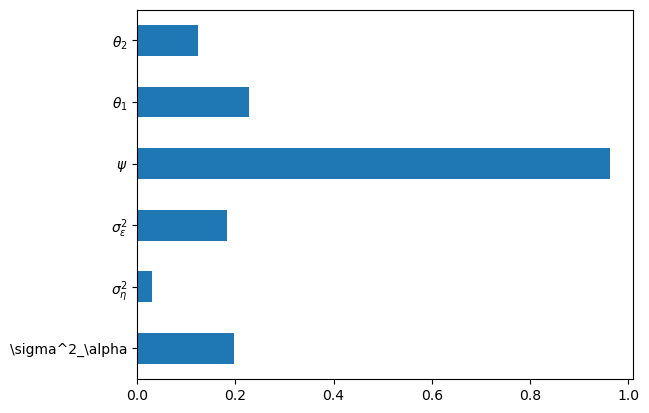

In [26]:
est_df.plot(kind='barh', legend=False)

In [29]:
help(opt)

Help on package scipy.optimize in scipy:

NAME
    scipy.optimize

DESCRIPTION
    Optimization and root finding (:mod:`scipy.optimize`)

    .. currentmodule:: scipy.optimize

    .. toctree::
       :hidden:

       optimize.cython_optimize

    SciPy ``optimize`` provides functions for minimizing (or maximizing)
    objective functions, possibly subject to constraints. It includes
    solvers for nonlinear problems (with support for both local and global
    optimization algorithms), linear programming, constrained
    and nonlinear least-squares, root finding, and curve fitting.

    Common functions and objects, shared across different solvers, are:

    .. autosummary::
       :toctree: generated/

       show_options - Show specific options optimization solvers.
       OptimizeResult - The optimization result returned by some optimizers.
       OptimizeWarning - The optimization encountered problems.


    Optimization

    Scalar functions optimization
    ---------------------